In [3]:
# STEP 1: Basic setup and imports
# Run this cell first after restarting the runtime

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Install required packages
!pip install onnx onnxruntime opencv-python -q

# Import all required libraries
import os
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import time
from collections import deque
import matplotlib.pyplot as plt
from google.colab import files
from google.colab.patches import cv2_imshow
from IPython.display import display, HTML, clear_output
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import glob
from tqdm.notebook import tqdm
import random
import warnings
warnings.filterwarnings("ignore")

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Clear GPU memory if needed
if device.type == 'cuda':
    torch.cuda.empty_cache()

# Define dataset paths - ADJUST THESE TO YOUR ACTUAL PATHS
PREFIX_DATASET_PATH = "/content/drive/MyDrive/data"
FOLDER_DATASET_PATH = "/content/drive/MyDrive/Peliculas"
FIGHTS_FOLDER = "/content/drive/MyDrive/Peliculas/fights"
NO_FIGHTS_FOLDER = "/content/drive/MyDrive/Peliculas/noFights"

# Verify paths
print(f"Prefix dataset path exists: {os.path.exists(PREFIX_DATASET_PATH)}")
print(f"Folder dataset path exists: {os.path.exists(FOLDER_DATASET_PATH)}")
print(f"Fights folder exists: {os.path.exists(FIGHTS_FOLDER)}")
print(f"No fights folder exists: {os.path.exists(NO_FIGHTS_FOLDER)}")

# Test basic PyTorch functionality
x = torch.randn(3, 3)
print("Test tensor created successfully!")
print(x)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Using device: cuda
Prefix dataset path exists: True
Folder dataset path exists: True
Fights folder exists: True
No fights folder exists: True
Test tensor created successfully!
tensor([[-1.6281,  0.0965, -1.5235],
        [-0.5859, -1.5678,  0.2688],
        [ 1.0405, -0.5528,  0.3179]])


In [4]:
# STEP 2: Define and test the VideoDataset class
# Run this cell after Step 1 completes successfully

class VideoDataset(Dataset):
    """Dataset for loading videos for violence detection"""

    def __init__(self, video_paths, labels, clip_duration=8, temporal_sample=8):
        self.video_paths = video_paths
        self.labels = labels
        self.clip_duration = clip_duration
        self.temporal_sample = temporal_sample

        # Print dataset information
        print(f"Created dataset with {len(video_paths)} videos")
        if len(video_paths) > 0:
            print(f"Violence videos: {sum(labels)}")
            print(f"Non-violence videos: {len(labels) - sum(labels)}")

    def __len__(self):
        return len(self.video_paths)

    def __getitem__(self, idx):
        video_path = self.video_paths[idx]
        label = self.labels[idx]

        try:
            # For this initial test, return dummy data instead of loading actual video
            # This helps verify the dataset class works without depending on video loading
            frames = torch.zeros((3, self.temporal_sample, 224, 224))
            label = torch.tensor(label, dtype=torch.long)
            return frames, label

        except Exception as e:
            print(f"Error processing item {idx}: {e}")
            frames = torch.zeros((3, self.temporal_sample, 224, 224))
            label = torch.tensor(label, dtype=torch.long)
            return frames, label

# Test the dataset with dummy data
dummy_paths = ["video1.mp4", "video2.mp4", "video3.mp4", "video4.mp4"]
dummy_labels = [0, 1, 1, 0]

test_dataset = VideoDataset(
    video_paths=dummy_paths,
    labels=dummy_labels,
    clip_duration=8,
    temporal_sample=8
)

print(f"Dataset length: {len(test_dataset)}")
print(f"First item shape: {test_dataset[0][0].shape}")
print(f"First item label: {test_dataset[0][1]}")

# Test creating a DataLoader
test_loader = DataLoader(test_dataset, batch_size=2, shuffle=True)
for batch_idx, (data, target) in enumerate(test_loader):
    print(f"Batch {batch_idx}: Data shape {data.shape}, Target shape {target.shape}")
    break

Created dataset with 4 videos
Violence videos: 2
Non-violence videos: 2
Dataset length: 4
First item shape: torch.Size([3, 8, 224, 224])
First item label: 0
Batch 0: Data shape torch.Size([2, 3, 8, 224, 224]), Target shape torch.Size([2])


In [5]:
# STEP 3: Define dataset loading functions
# Run this cell after Step 2 completes successfully

def prepare_datasets_from_drive():
    """Prepare datasets from Google Drive paths"""
    all_video_paths = []
    all_labels = []

    # Define supported video formats - including MPG
    supported_formats = ['.mp4', '.avi', '.mov', '.mkv', '.mpg', '.mpeg']

    # Process prefix-based dataset (videos with "fi" and "no" prefixes)
    if os.path.exists(PREFIX_DATASET_PATH):
        print(f"Loading prefix-based dataset from {PREFIX_DATASET_PATH}")

        # Get all video files with multiple formats
        video_files = []
        for ext in supported_formats:
            video_files.extend(glob.glob(os.path.join(PREFIX_DATASET_PATH, f"*{ext}")))

        print(f"Found {len(video_files)} video files in prefix dataset")

        for video_path in video_files:
            filename = os.path.basename(video_path).lower()
            if filename.startswith("fi"):
                # Fight video
                all_video_paths.append(video_path)
                all_labels.append(1)  # 1 for violence
            elif filename.startswith("no"):
                # Non-fight video
                all_video_paths.append(video_path)
                all_labels.append(0)  # 0 for non-violence

    # Process folder-based dataset (separate folders for fights and noFights)
    if os.path.exists(FIGHTS_FOLDER):
        print(f"Loading fight videos from {FIGHTS_FOLDER}")

        # Fight videos - multiple formats
        fight_videos = []
        for ext in supported_formats:
            fight_videos.extend(glob.glob(os.path.join(FIGHTS_FOLDER, f"*{ext}")))

        print(f"Found {len(fight_videos)} fight videos")

        all_video_paths.extend(fight_videos)
        all_labels.extend([1] * len(fight_videos))

    if os.path.exists(NO_FIGHTS_FOLDER):
        print(f"Loading non-fight videos from {NO_FIGHTS_FOLDER}")

        # Non-fight videos - multiple formats
        nofight_videos = []
        for ext in supported_formats:
            nofight_videos.extend(glob.glob(os.path.join(NO_FIGHTS_FOLDER, f"*{ext}")))

        print(f"Found {len(nofight_videos)} non-fight videos")

        all_video_paths.extend(nofight_videos)
        all_labels.extend([0] * len(nofight_videos))

    print(f"Total videos loaded: {len(all_video_paths)}")
    if len(all_video_paths) > 0:
        print(f"Violence videos: {sum(all_labels)}")
        print(f"Non-violence videos: {len(all_labels) - sum(all_labels)}")

    return all_video_paths, all_labels

def train_val_split(video_paths, labels, val_ratio=0.2, seed=42):
    """Split dataset into training and validation sets"""
    # Set random seed for reproducibility
    random.seed(seed)

    # Check if dataset is empty
    if len(video_paths) == 0:
        return [], [], [], []

    # Create pairs of (path, label)
    pairs = list(zip(video_paths, labels))

    # Shuffle pairs
    random.shuffle(pairs)

    # Split into train and validation sets
    val_size = max(1, int(len(pairs) * val_ratio))  # Ensure at least 1 validation sample
    train_pairs = pairs[val_size:]
    val_pairs = pairs[:val_size]

    # Unzip pairs
    train_paths, train_labels = zip(*train_pairs) if train_pairs else ([], [])
    val_paths, val_labels = zip(*val_pairs) if val_pairs else ([], [])

    return train_paths, train_labels, val_paths, val_labels

# Test dataset loading with a small sample
all_paths, all_labels = prepare_datasets_from_drive()

# If datasets were found, test the split function
if len(all_paths) > 0:
    # Only use a small sample to test (first 100 videos)
    sample_size = min(100, len(all_paths))
    sample_paths = all_paths[:sample_size]
    sample_labels = all_labels[:sample_size]

    # Test train/val split
    train_paths, train_labels, val_paths, val_labels = train_val_split(
        sample_paths, sample_labels, val_ratio=0.2
    )

    print(f"Split test sample into {len(train_paths)} training and {len(val_paths)} validation videos")

Loading prefix-based dataset from /content/drive/MyDrive/data
Found 1000 video files in prefix dataset
Loading fight videos from /content/drive/MyDrive/Peliculas/fights
Found 100 fight videos
Loading non-fight videos from /content/drive/MyDrive/Peliculas/noFights
Found 101 non-fight videos
Total videos loaded: 1201
Violence videos: 600
Non-violence videos: 601
Split test sample into 80 training and 20 validation videos


In [6]:
# STEP 4: Define the model architecture
# Run this cell after Step 3 completes successfully

class LightweightViolenceDetector(nn.Module):
    """Lightweight 3D CNN for violence detection based on MobileNetV3 principles"""

    def __init__(self, num_frames=8, num_classes=2):
        super(LightweightViolenceDetector, self).__init__()

        # Initial convolution layer
        self.conv1 = nn.Conv3d(3, 16, kernel_size=(3, 3, 3), stride=(1, 2, 2), padding=(1, 1, 1))
        self.bn1 = nn.BatchNorm3d(16)
        self.relu1 = nn.ReLU(inplace=True)

        # Inverted residual blocks (simplified from MobileNetV3)
        # Block 1
        self.block1_dw = nn.Conv3d(16, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), groups=16)
        self.block1_bn1 = nn.BatchNorm3d(16)
        self.block1_relu = nn.ReLU(inplace=True)
        self.block1_pw = nn.Conv3d(16, 32, kernel_size=1)
        self.block1_bn2 = nn.BatchNorm3d(32)

        # Block 2
        self.block2_dw = nn.Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 2, 2), padding=(1, 1, 1), groups=32)
        self.block2_bn1 = nn.BatchNorm3d(32)
        self.block2_relu = nn.ReLU(inplace=True)
        self.block2_pw = nn.Conv3d(32, 64, kernel_size=1)
        self.block2_bn2 = nn.BatchNorm3d(64)

        # Global average pooling and classification
        self.global_pool = nn.AdaptiveAvgPool3d((1, 1, 1))
        self.dropout = nn.Dropout(0.2)
        self.fc = nn.Linear(64, num_classes)

    def forward(self, x):
        # Initial convolution
        x = self.relu1(self.bn1(self.conv1(x)))

        # Block 1
        x = self.block1_relu(self.block1_bn1(self.block1_dw(x)))
        x = self.block1_bn2(self.block1_pw(x))

        # Block 2
        x = self.block2_relu(self.block2_bn1(self.block2_dw(x)))
        x = self.block2_bn2(self.block2_pw(x))

        # Global average pooling
        x = self.global_pool(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(x)

        # Classification
        x = self.fc(x)

        return x

# Test the model
model = LightweightViolenceDetector().to(device)
print("Model created successfully!")

# Verify model has parameters
param_count = sum(p.numel() for p in model.parameters())
print(f"Model has {param_count} trainable parameters")

# Test forward pass with dummy input
dummy_input = torch.randn(2, 3, 8, 224, 224).to(device)
dummy_output = model(dummy_input)
print(f"Model output shape: {dummy_output.shape}")

Model created successfully!
Model has 5762 trainable parameters
Model output shape: torch.Size([2, 2])


Epoch 1/1


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1/1, Train Loss: 0.6940, Val Loss: 0.8128, Val Accuracy: 0.0000
Error loading best model: Error(s) in loading state_dict for LightweightViolenceDetector:
	Missing key(s) in state_dict: "block1_dw.weight", "block1_dw.bias", "block1_bn1.weight", "block1_bn1.bias", "block1_bn1.running_mean", "block1_bn1.running_var", "block1_pw.weight", "block1_pw.bias", "block1_bn2.weight", "block1_bn2.bias", "block1_bn2.running_mean", "block1_bn2.running_var", "block2_dw.weight", "block2_dw.bias", "block2_bn1.weight", "block2_bn1.bias", "block2_bn1.running_mean", "block2_bn1.running_var", "block2_pw.weight", "block2_pw.bias", "block2_bn2.weight", "block2_bn2.bias", "block2_bn2.running_mean", "block2_bn2.running_var". 
	size mismatch for fc.weight: copying a param with shape torch.Size([2, 16]) from checkpoint, the shape in current model is torch.Size([2, 64]).
Training function test completed successfully!


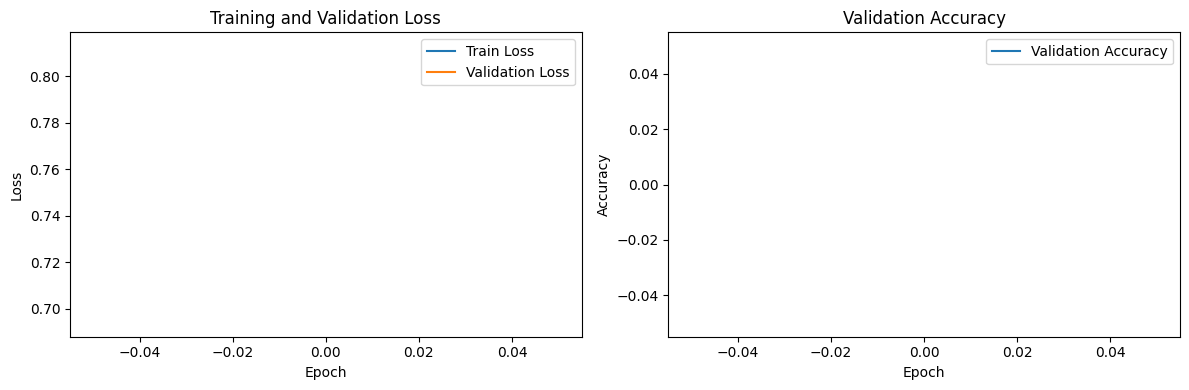

In [7]:
# STEP 5: Define training functions
# Run this cell after Step 4 completes successfully

def train_model(model, train_loader, val_loader, criterion, optimizer,
                scheduler, num_epochs=10, device=device, save_path="models"):
    """Train the model"""
    # Create save directory
    os.makedirs(save_path, exist_ok=True)

    # Training history
    history = {
        'train_loss': [],
        'val_loss': [],
        'val_accuracy': []
    }

    # Best validation accuracy
    best_val_acc = 0.0

    # Start training
    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")

        # Training phase
        model.train()
        running_loss = 0.0
        train_samples = 0

        # Progress bar for training
        train_pbar = tqdm(train_loader, desc=f"Training")

        for inputs, labels in train_pbar:
            # Move inputs and labels to device
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            # Update statistics
            batch_size = inputs.size(0)
            running_loss += loss.item() * batch_size
            train_samples += batch_size

            # Update progress bar
            train_pbar.set_postfix({'loss': loss.item()})

            # Clear GPU memory if needed
            if device.type == 'cuda':
                torch.cuda.empty_cache()

        epoch_train_loss = running_loss / train_samples if train_samples > 0 else 0
        history['train_loss'].append(epoch_train_loss)

        # Validation phase
        model.eval()
        running_loss = 0.0
        correct = 0
        val_samples = 0

        # Progress bar for validation
        val_pbar = tqdm(val_loader, desc=f"Validation")

        with torch.no_grad():
            for inputs, labels in val_pbar:
                # Move inputs and labels to device
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Forward pass
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                # Get predictions
                _, preds = torch.max(outputs, 1)

                # Update statistics
                batch_size = inputs.size(0)
                running_loss += loss.item() * batch_size
                correct += torch.sum(preds == labels).item()
                val_samples += batch_size

                # Update progress bar
                val_pbar.set_postfix({'loss': loss.item()})

        epoch_val_loss = running_loss / val_samples if val_samples > 0 else 0
        epoch_val_acc = correct / val_samples if val_samples > 0 else 0

        history['val_loss'].append(epoch_val_loss)
        history['val_accuracy'].append(epoch_val_acc)

        # Print epoch statistics
        print(f"Epoch {epoch+1}/{num_epochs}, "
              f"Train Loss: {epoch_train_loss:.4f}, "
              f"Val Loss: {epoch_val_loss:.4f}, "
              f"Val Accuracy: {epoch_val_acc:.4f}")

        # Update learning rate
        scheduler.step(epoch_val_loss)

        # Save best model
        if epoch_val_acc > best_val_acc:
            best_val_acc = epoch_val_acc
            try:
                torch.save(model.state_dict(), os.path.join(save_path, "best_violence_detector.pth"))
                print(f"Saved best model with validation accuracy: {best_val_acc:.4f}")
            except Exception as e:
                print(f"Error saving model: {e}")

    # Load best model
    try:
        best_model_path = os.path.join(save_path, "best_violence_detector.pth")
        if os.path.exists(best_model_path):
            model.load_state_dict(torch.load(best_model_path, map_location=device))
            print(f"Loaded best model from {best_model_path}")
    except Exception as e:
        print(f"Error loading best model: {e}")

    return model, history

def plot_training_history(history):
    """Plot training history"""
    plt.figure(figsize=(12, 4))

    # Plot training and validation loss
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    # Plot validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Validation Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Test the training functions with dummy data
def test_training_function():
    # Create small dummy dataset
    dummy_dataset_size = 10
    dummy_inputs = torch.randn(dummy_dataset_size, 3, 8, 224, 224)
    dummy_labels = torch.randint(0, 2, (dummy_dataset_size,))

    # Create dummy datasets and dataloaders
    class DummyDataset(Dataset):
        def __init__(self, inputs, labels):
            self.inputs = inputs
            self.labels = labels

        def __len__(self):
            return len(self.inputs)

        def __getitem__(self, idx):
            return self.inputs[idx], self.labels[idx]

    dummy_train_dataset = DummyDataset(dummy_inputs[:8], dummy_labels[:8])
    dummy_val_dataset = DummyDataset(dummy_inputs[8:], dummy_labels[8:])

    dummy_train_loader = DataLoader(dummy_train_dataset, batch_size=2, shuffle=True)
    dummy_val_loader = DataLoader(dummy_val_dataset, batch_size=2, shuffle=False)

    # Create model and training components
    model = LightweightViolenceDetector().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=2)

    # Test training for 1 epoch
    model, history = train_model(
        model, dummy_train_loader, dummy_val_loader, criterion, optimizer, scheduler, num_epochs=1
    )

    print("Training function test completed successfully!")

    return history

# Run the test
test_history = test_training_function()
plot_training_history(test_history)

Created dataset with 1 videos
Violence videos: 1
Non-violence videos: 0
Loaded frames shape: torch.Size([3, 8, 224, 224])
Loaded label: 1


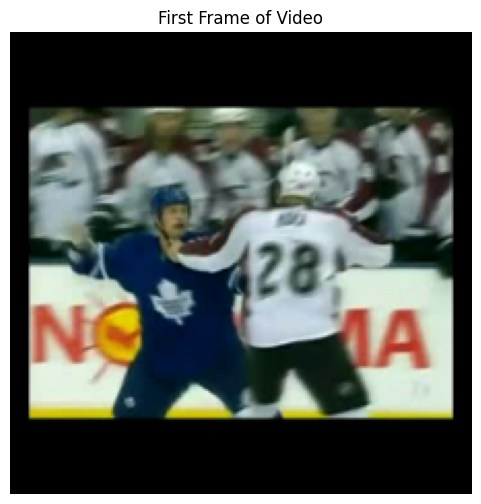

True

In [8]:
# STEP 6: Complete VideoDataset with video loading
# Run this cell after Step 5 completes successfully

# Now we'll enhance the VideoDataset class to load actual videos
class VideoDataset(Dataset):
    """Dataset for loading videos for violence detection"""

    def __init__(self, video_paths, labels, clip_duration=8, temporal_sample=8):
        self.video_paths = video_paths
        self.labels = labels
        self.clip_duration = clip_duration
        self.temporal_sample = temporal_sample

        # Print dataset information
        print(f"Created dataset with {len(video_paths)} videos")
        if len(video_paths) > 0:
            print(f"Violence videos: {sum(labels)}")
            print(f"Non-violence videos: {len(labels) - sum(labels)}")

    def __len__(self):
        return len(self.video_paths)

    def __getitem__(self, idx):
        video_path = self.video_paths[idx]
        label = self.labels[idx]

        try:
            # Load video frames and preprocess
            frames = self._load_video(video_path)

            # Convert label to tensor
            label = torch.tensor(label, dtype=torch.long)

            return frames, label

        except Exception as e:
            print(f"Error loading video {video_path}: {e}")
            # Return a blank tensor and the label in case of error
            frames = torch.zeros((3, self.temporal_sample, 224, 224))
            label = torch.tensor(label, dtype=torch.long)
            return frames, label

    def _load_video(self, video_path):
        """Load video frames and preprocess"""
        frames = []
        try:
            cap = cv2.VideoCapture(video_path)
            if not cap.isOpened():
                raise Exception(f"Cannot open video file: {video_path}")

            # Read frames
            frame_count = 0
            while len(frames) < self.clip_duration and frame_count < 100:
                ret, frame = cap.read()
                if not ret:
                    break

                # Convert BGR to RGB
                frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

                # Resize frame to 224x224
                frame = cv2.resize(frame, (224, 224))

                frames.append(frame)
                frame_count += 1

            cap.release()

            # If we don't have enough frames, duplicate the last frame
            if 0 < len(frames) < self.clip_duration:
                last_frame = frames[-1]
                while len(frames) < self.clip_duration:
                    frames.append(last_frame)

            # If we couldn't read any frames, create blank frames
            if len(frames) == 0:
                blank_frame = np.zeros((224, 224, 3), dtype=np.uint8)
                frames = [blank_frame] * self.clip_duration
                print(f"Warning: Could not read frames from {video_path}")

            # Stack frames into a single numpy array: [T, H, W, C]
            frames = np.stack(frames, axis=0)

            # Subsample temporally to save memory
            if self.temporal_sample < self.clip_duration:
                indices = np.linspace(0, len(frames) - 1, self.temporal_sample, dtype=int)
                frames = frames[indices]

            # Convert to float and normalize (0-1 range)
            frames = frames.astype(np.float32) / 255.0

            # Convert to tensor [C, T, H, W]
            frames = torch.from_numpy(frames).permute(3, 0, 1, 2)

            return frames

        except Exception as e:
            raise Exception(f"Error in _load_video for {video_path}: {e}")

# Test the enhanced dataset with a single real video if available
def test_video_dataset():
    if len(all_paths) > 0:
        # Just test with the first video
        test_video_dataset = VideoDataset(
            video_paths=[all_paths[0]],
            labels=[all_labels[0]],
            clip_duration=8,
            temporal_sample=8
        )

        # Try loading the video
        frames, label = test_video_dataset[0]
        print(f"Loaded frames shape: {frames.shape}")
        print(f"Loaded label: {label}")

        # Display first frame
        plt.figure(figsize=(6, 6))
        plt.imshow(frames[:, 0].permute(1, 2, 0))
        plt.title("First Frame of Video")
        plt.axis('off')
        plt.show()

        return True
    else:
        print("No videos available to test")
        return False

# Run the test
test_video_dataset()

Loading prefix-based dataset from /content/drive/MyDrive/data
Found 1000 video files in prefix dataset
Loading fight videos from /content/drive/MyDrive/Peliculas/fights
Found 100 fight videos
Loading non-fight videos from /content/drive/MyDrive/Peliculas/noFights
Found 101 non-fight videos
Total videos loaded: 1201
Violence videos: 600
Non-violence videos: 601
Using a sample of 10 videos for training
Created dataset with 8 videos
Violence videos: 4
Non-violence videos: 4
Created dataset with 2 videos
Violence videos: 1
Non-violence videos: 1
Epoch 1/2


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1/2, Train Loss: 0.6863, Val Loss: 0.6941, Val Accuracy: 0.5000
Saved best model with validation accuracy: 0.5000
Epoch 2/2


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 2/2, Train Loss: 0.6506, Val Loss: 0.6980, Val Accuracy: 0.5000
Loaded best model from models/best_violence_detector.pth


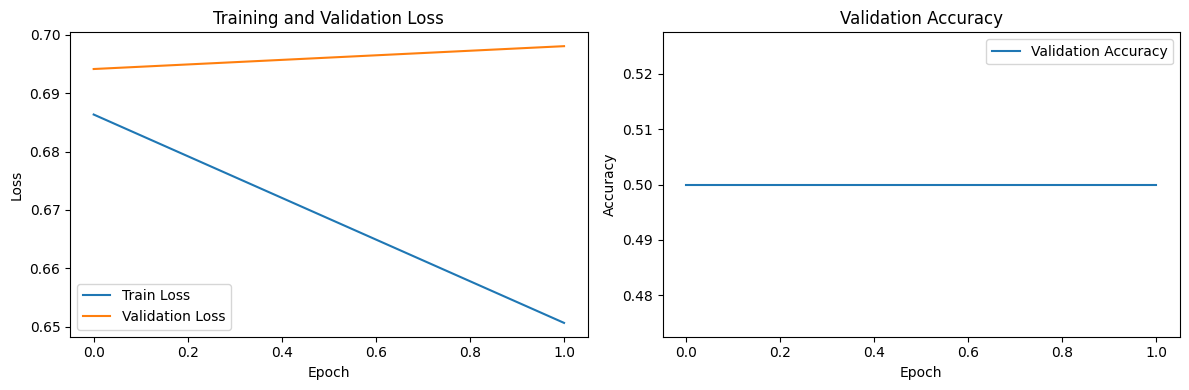

Model exported to models/violence_detector.onnx


In [9]:
# STEP 7: Full training pipeline with smaller batch size
# Run this cell after Step 6 completes successfully

def train_with_smaller_batches(sample_size=None, num_epochs=10):
    """Train violence detection model with smaller batches to avoid memory issues"""
    try:
        # Clear GPU memory
        if device.type == 'cuda':
            torch.cuda.empty_cache()

        # Step 1: Prepare datasets from Google Drive
        video_paths, labels = prepare_datasets_from_drive()

        if len(video_paths) == 0:
            print("No videos found! Please check your dataset paths.")
            return None, None

        # Optionally use only a subset for testing
        if sample_size is not None and sample_size < len(video_paths):
            print(f"Using a sample of {sample_size} videos for training")
            # Create a balanced sample with equal violent and non-violent videos
            violent_paths = [p for p, l in zip(video_paths, labels) if l == 1]
            nonviolent_paths = [p for p, l in zip(video_paths, labels) if l == 0]

            sample_per_class = sample_size // 2
            sampled_violent = violent_paths[:sample_per_class]
            sampled_nonviolent = nonviolent_paths[:sample_per_class]

            video_paths = sampled_violent + sampled_nonviolent
            labels = [1] * len(sampled_violent) + [0] * len(sampled_nonviolent)

        # Step 2: Split into train and validation sets
        train_paths, train_labels, val_paths, val_labels = train_val_split(
            video_paths, labels, val_ratio=0.2
        )

        # Step 3: Create datasets and data loaders
        train_dataset = VideoDataset(
            video_paths=train_paths,
            labels=train_labels,
            clip_duration=8,  # Reduced from 16 to save memory
            temporal_sample=8
        )

        val_dataset = VideoDataset(
            video_paths=val_paths,
            labels=val_labels,
            clip_duration=8,  # Reduced from 16 to save memory
            temporal_sample=8
        )

        # Use a very small batch size to avoid memory issues
        batch_size = 2  # Very small batch size
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

        # Step 4: Create model
        model = LightweightViolenceDetector().to(device)

        # Step 5: Define loss function, optimizer, and scheduler
        # Class weights to handle imbalanced dataset
        class_counts = [train_labels.count(0), train_labels.count(1)]

        # Ensure we don't divide by zero
        if class_counts[1] == 0 or class_counts[0] == 0:
            class_weights = torch.tensor([1.0, 1.0]).to(device)
        else:
            class_weights = torch.tensor([1.0, class_counts[0] / class_counts[1]]).to(device)

        criterion = nn.CrossEntropyLoss(weight=class_weights)
        optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, mode='min', factor=0.1, patience=5, verbose=True
        )

        # Step 6: Train model
        model, history = train_model(
            model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=num_epochs
        )

        # Step 7: Plot training history
        plot_training_history(history)

        # Step 8: Export model to ONNX
        export_to_onnx(model)

        return model, history

    except Exception as e:
        print(f"Error in train_with_smaller_batches function: {e}")
        import traceback
        traceback.print_exc()
        return None, None

def export_to_onnx(model, input_shape=(1, 3, 8, 224, 224), output_path="models/violence_detector.onnx"):
    """Export PyTorch model to ONNX format"""
    try:
        # Create directory if it doesn't exist
        os.makedirs(os.path.dirname(output_path), exist_ok=True)

        model.eval()

        # Create dummy input
        dummy_input = torch.randn(input_shape, device=device)

        # Export model
        torch.onnx.export(
            model,
            dummy_input,
            output_path,
            export_params=True,
            opset_version=12,
            do_constant_folding=True,
            input_names=['input'],
            output_names=['output'],
            dynamic_axes={
                'input': {0: 'batch_size'},
                'output': {0: 'batch_size'}
            }
        )

        print(f"Model exported to {output_path}")
        return output_path
    except Exception as e:
        print(f"Error exporting model to ONNX: {e}")
        return None

# Run training on a small sample first as a test
# Use a very small sample (10 videos) and just 2 epochs to test the pipeline
model, history = train_with_smaller_batches(sample_size=10, num_epochs=2)

# If successful, you can run the full training:
# model, history = train_with_smaller_batches(num_epochs=20)

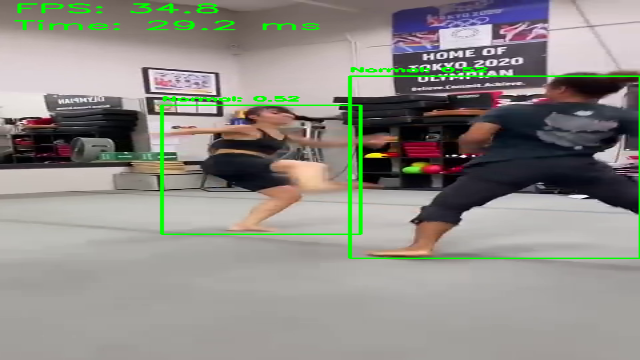


No violent segments detected.
Output video saved to processed_WhatsApp Video 2025-03-02 at 11.44.04_afc97ec1.mp4


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [10]:
# STEP 8: Real-time violence detection system
# Run this after training is complete

class ViolenceDetector:
    """Real-time violence detection system"""

    def __init__(self, model_path, confidence_threshold=0.85, device=device, use_onnx=True):
        """
        Initialize violence detector

        Args:
            model_path: Path to model weights (PyTorch .pth or ONNX .onnx)
            confidence_threshold: Confidence threshold for violence detection
            device: Device to run inference on
            use_onnx: Whether to use ONNX for inference
        """
        self.confidence_threshold = confidence_threshold
        self.device = device
        self.use_onnx = use_onnx and model_path is not None and model_path.endswith('.onnx')

        # Load model
        self.load_model(model_path)

        # Frame buffer for temporal processing
        self.frame_buffer = deque(maxlen=8)

        # For processing stats
        self.processing_times = deque(maxlen=30)

    def load_model(self, model_path):
        """Load model from path"""
        try:
            if self.use_onnx:
                import onnxruntime as ort

                # Set up ONNX runtime session
                providers = ['CUDAExecutionProvider', 'CPUExecutionProvider'] if self.device.type == "cuda" else ['CPUExecutionProvider']
                self.session = ort.InferenceSession(model_path, providers=providers)
                self.input_name = self.session.get_inputs()[0].name
                self.label_name = self.session.get_outputs()[0].name
                self.model = None

                print(f"Loaded ONNX model from {model_path}")
            else:
                # Load PyTorch model
                self.model = LightweightViolenceDetector()
                self.model.load_state_dict(torch.load(model_path, map_location=self.device))
                self.model.to(self.device)
                self.model.eval()
                self.session = None

                print(f"Loaded PyTorch model from {model_path}")
        except Exception as e:
            print(f"Error loading model: {e}")
            # Create a default model
            self.model = LightweightViolenceDetector().to(self.device)
            self.model.eval()
            self.session = None
            print("Created a new model since loading failed")

    def load_person_detector(self):
        """Load YOLOv5 person detector"""
        try:
            print("Loading YOLOv5 person detector...")
            self.person_detector = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True)
            self.person_detector.to(self.device)
            self.person_detector.classes = [0]  # Only detect people (class 0 in COCO)
            print("Person detector loaded successfully")
            return True
        except Exception as e:
            print(f"Error loading person detector: {e}")
            self.person_detector = None
            return False

    def detect_people(self, frame):
        """Detect people in frame"""
        if not hasattr(self, 'person_detector'):
            if not self.load_person_detector():
                # If person detector failed, use whole frame
                height, width = frame.shape[:2]
                return [(0, 0, width, height, 1.0)]

        try:
            results = self.person_detector(frame)

            boxes = []
            for detection in results.xyxy[0]:
                if detection[5] == 0:  # Class 0 is person
                    if detection[4] > 0.5:  # Confidence threshold
                        x1, y1, x2, y2 = map(int, detection[:4])
                        confidence = detection[4].item()
                        boxes.append((x1, y1, x2, y2, confidence))

            # If no people detected, use whole frame
            if not boxes:
                height, width = frame.shape[:2]
                boxes.append((0, 0, width, height, 1.0))

            return boxes
        except Exception as e:
            print(f"Error in person detection: {e}")
            # Return whole frame
            height, width = frame.shape[:2]
            return [(0, 0, width, height, 1.0)]

    def preprocess_clip(self, frames):
        """Preprocess frames for violence detection"""
        try:
            # Resize frames
            resized_frames = [cv2.resize(frame, (224, 224)) for frame in frames]

            # Convert to tensor and normalize
            clip = torch.tensor(np.array(resized_frames) / 255.0, dtype=torch.float32)

            # Transpose from [T, H, W, C] to [C, T, H, W] for 3D CNN
            clip = clip.permute(3, 0, 1, 2)

            # Add batch dimension
            clip = clip.unsqueeze(0)

            return clip
        except Exception as e:
            print(f"Error preprocessing clip: {e}")
            # Return an empty tensor
            return torch.zeros((1, 3, len(frames), 224, 224))

    def detect_violence(self, clip):
        """Detect violence in clip"""
        try:
            if self.use_onnx and self.session is not None:
                # ONNX inference
                ort_inputs = {self.input_name: clip.cpu().numpy()}
                ort_outputs = self.session.run(None, ort_inputs)
                scores = ort_outputs[0][0]

                # Convert to probabilities
                probabilities = F.softmax(torch.tensor(scores), dim=0)
            else:
                # PyTorch inference
                with torch.no_grad():
                    clip = clip.to(self.device)
                    outputs = self.model(clip)
                    probabilities = F.softmax(outputs[0], dim=0)

            # Get violence probability (assuming class 1 is violence)
            violence_prob = probabilities[1].item()
            is_violent = violence_prob > self.confidence_threshold

            return is_violent, violence_prob
        except Exception as e:
            print(f"Error in violence detection: {e}")
            return False, 0.0

    def process_frame(self, frame):
        """Process a single frame for violence detection"""
        start_time = time.time()

        try:
            # Make a copy for visualization
            vis_frame = frame.copy()

            # Add frame to buffer
            self.frame_buffer.append(frame)

            # Skip if buffer isn't full yet
            if len(self.frame_buffer) < 8:
                # Display that we're collecting frames
                cv2.putText(vis_frame, "Collecting frames...", (10, 30),
                           cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)

                processing_time = time.time() - start_time
                self.processing_times.append(processing_time)
                fps = 1.0 / (sum(self.processing_times) / len(self.processing_times))

                # Display FPS
                cv2.putText(vis_frame, f"FPS: {fps:.1f}", (10, 70),
                           cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

                return vis_frame

            # Detect people
            person_boxes = self.detect_people(frame)

            # Process each person region
            for box in person_boxes:
                x1, y1, x2, y2, confidence = box

                # Extract person region from each frame in buffer
                person_clips = []
                for buffered_frame in self.frame_buffer:
                    # Ensure valid coordinates
                    valid_x1 = max(0, x1)
                    valid_y1 = max(0, y1)
                    valid_x2 = min(buffered_frame.shape[1], x2)
                    valid_y2 = min(buffered_frame.shape[0], y2)

                    if valid_x2 <= valid_x1 or valid_y2 <= valid_y1:
                        # Invalid region, use whole frame
                        region = buffered_frame
                    else:
                        # Extract valid region
                        region = buffered_frame[valid_y1:valid_y2, valid_x1:valid_x2]

                    person_clips.append(region)

                # Preprocess clip
                clip = self.preprocess_clip(person_clips)

                # Detect violence
                is_violent, violence_prob = self.detect_violence(clip)

                # Draw bounding box
                color = (0, 0, 255) if is_violent else (0, 255, 0)
                cv2.rectangle(vis_frame, (x1, y1), (x2, y2), color, 2)

                # Add label
                label = f"Violent: {violence_prob:.2f}" if is_violent else f"Normal: {1-violence_prob:.2f}"
                cv2.putText(vis_frame, label, (x1, y1-10),
                           cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

            # Calculate processing time and FPS
            processing_time = time.time() - start_time
            self.processing_times.append(processing_time)
            fps = 1.0 / (sum(self.processing_times) / len(self.processing_times))

            # Display FPS and processing time
            cv2.putText(vis_frame, f"FPS: {fps:.1f}", (10, 30),
                       cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
            cv2.putText(vis_frame, f"Time: {processing_time*1000:.1f} ms", (10, 70),
                       cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

            return vis_frame
        except Exception as e:
            print(f"Error processing frame: {e}")
            # Return original frame with error
            cv2.putText(frame, f"Error: {str(e)[:50]}", (10, 30),
                       cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)
            return frame

    def process_uploaded_video(self):
        """Process a video uploaded to Colab"""
        try:
            # Upload video
            print("Please upload a video file to process...")
            uploaded = files.upload()

            if not uploaded:
                print("No file uploaded.")
                return

            # Get uploaded video path
            video_path = next(iter(uploaded))

            # Process video
            output_path = f"processed_{video_path}"
            self.process_video(video_path, output_path)

        except Exception as e:
            print(f"Error processing uploaded video: {e}")

    def process_video(self, video_path, output_path=None, display_interval=30):
        """Process a video file"""
        try:
            # Open video
            cap = cv2.VideoCapture(video_path)
            if not cap.isOpened():
                print(f"Error: Could not open video {video_path}")
                return

            # Get video properties
            width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
            height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
            fps = cap.get(cv2.CAP_PROP_FPS)
            frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

            print(f"Video properties: {width}x{height}, {fps} FPS, {frame_count} frames")

            # Create output video if requested
            if output_path:
                fourcc = cv2.VideoWriter_fourcc(*'mp4v')
                out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

            # Initialize frame counter
            frame_idx = 0

            # Process frames
            violent_segments = []
            current_segment = None

            # Create progress bar
            from tqdm.notebook import tqdm
            progress_bar = tqdm(total=frame_count, desc="Processing video")

            while cap.isOpened():
                ret, frame = cap.read()
                if not ret:
                    break

                # Process every other frame for speed
                if frame_idx % 2 == 0:
                    # Process frame
                    processed_frame = self.process_frame(frame)

                    # Check for violence in whole frame
                    if len(self.frame_buffer) >= 8:
                        clip = self.preprocess_clip(list(self.frame_buffer))
                        is_violent, violence_prob = self.detect_violence(clip)

                        # Track violent segments
                        if is_violent:
                            if current_segment is None:
                                current_segment = {'start': frame_idx / fps, 'end': frame_idx / fps}
                            else:
                                current_segment['end'] = frame_idx / fps
                        elif current_segment is not None:
                            violent_segments.append(current_segment)
                            current_segment = None

                    # Write to output video if requested
                    if output_path:
                        out.write(processed_frame)

                    # Display frame periodically
                    if frame_idx % display_interval == 0:
                        # Show a frame in Colab
                        if frame_idx > 0 and frame_idx % (display_interval * 10) == 0:
                            clear_output(wait=True)
                            display_frame = cv2.resize(processed_frame, (640, 360))
                            cv2_imshow(display_frame)

                frame_idx += 1
                progress_bar.update(1)

            # Add final violent segment if exists
            if current_segment is not None:
                violent_segments.append(current_segment)

            # Release resources
            cap.release()
            if output_path:
                out.release()
            progress_bar.close()

            # Print violent segments
            if violent_segments:
                print("\nDetected violent segments:")
                for i, segment in enumerate(violent_segments):
                    print(f"Segment {i+1}: {segment['start']:.2f}s - {segment['end']:.2f}s (duration: {segment['end']-segment['start']:.2f}s)")
            else:
                print("\nNo violent segments detected.")

            # Download output video
            if output_path:
                print(f"Output video saved to {output_path}")
                try:
                    files.download(output_path)
                except Exception as e:
                    print(f"Error downloading video: {e}")
                    print("You can manually download the video from the file browser.")

        except Exception as e:
            print(f"Error processing video: {e}")
            import traceback
            traceback.print_exc()

# After training, you can load and use the model:
# If you have a trained model (from previous training or the initial test)
model_path = "models/best_violence_detector.pth"  # Or "models/violence_detector.onnx"

if os.path.exists(model_path):
    # Initialize detector
    detector = ViolenceDetector(model_path=model_path, use_onnx=model_path.endswith('.onnx'))

    # Process uploaded video
    detector.process_uploaded_video()
else:
    print(f"No trained model found at {model_path}. Train the model first.")

In [11]:
# Complete Violence Detection Training Code
# =========================================

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Install required packages
!pip install onnx onnxruntime opencv-python -q

# Import all necessary libraries
import os
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import time
from collections import deque
import matplotlib.pyplot as plt
from google.colab import files
from google.colab.patches import cv2_imshow
from IPython.display import display, HTML, clear_output
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import glob
from tqdm.notebook import tqdm
import random
import warnings
warnings.filterwarnings("ignore")

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Clear GPU memory
if device.type == 'cuda':
    torch.cuda.empty_cache()

# Define dataset paths - ADJUST THESE TO YOUR ACTUAL PATHS
PREFIX_DATASET_PATH = "/content/drive/MyDrive/data"
FOLDER_DATASET_PATH = "/content/drive/MyDrive/Peliculas"
FIGHTS_FOLDER = "/content/drive/MyDrive/Peliculas/fights"
NO_FIGHTS_FOLDER = "/content/drive/MyDrive/Peliculas/noFights"

# Verify paths
print(f"Prefix dataset path exists: {os.path.exists(PREFIX_DATASET_PATH)}")
print(f"Folder dataset path exists: {os.path.exists(FOLDER_DATASET_PATH)}")
print(f"Fights folder exists: {os.path.exists(FIGHTS_FOLDER)}")
print(f"No fights folder exists: {os.path.exists(NO_FIGHTS_FOLDER)}")

# VideoDataset class
class VideoDataset(Dataset):
    """Dataset for loading videos for violence detection"""

    def __init__(self, video_paths, labels, clip_duration=8, temporal_sample=8):
        self.video_paths = video_paths
        self.labels = labels
        self.clip_duration = clip_duration
        self.temporal_sample = temporal_sample

        # Print dataset information
        print(f"Created dataset with {len(video_paths)} videos")
        if len(video_paths) > 0:
            print(f"Violence videos: {sum(labels)}")
            print(f"Non-violence videos: {len(labels) - sum(labels)}")

    def __len__(self):
        return len(self.video_paths)

    def __getitem__(self, idx):
        video_path = self.video_paths[idx]
        label = self.labels[idx]

        try:
            # Load video frames and preprocess
            frames = self._load_video(video_path)

            # Convert label to tensor
            label = torch.tensor(label, dtype=torch.long)

            return frames, label

        except Exception as e:
            print(f"Error loading video {video_path}: {e}")
            # Return a blank tensor and the label in case of error
            frames = torch.zeros((3, self.temporal_sample, 224, 224))
            label = torch.tensor(label, dtype=torch.long)
            return frames, label

    def _load_video(self, video_path):
        """Load video frames and preprocess"""
        frames = []
        try:
            cap = cv2.VideoCapture(video_path)
            if not cap.isOpened():
                raise Exception(f"Cannot open video file: {video_path}")

            # Read frames
            frame_count = 0
            while len(frames) < self.clip_duration and frame_count < 100:
                ret, frame = cap.read()
                if not ret:
                    break

                # Convert BGR to RGB
                frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

                # Resize frame to 224x224
                frame = cv2.resize(frame, (224, 224))

                frames.append(frame)
                frame_count += 1

            cap.release()

            # If we don't have enough frames, duplicate the last frame
            if 0 < len(frames) < self.clip_duration:
                last_frame = frames[-1]
                while len(frames) < self.clip_duration:
                    frames.append(last_frame)

            # If we couldn't read any frames, create blank frames
            if len(frames) == 0:
                blank_frame = np.zeros((224, 224, 3), dtype=np.uint8)
                frames = [blank_frame] * self.clip_duration
                print(f"Warning: Could not read frames from {video_path}")

            # Stack frames into a single numpy array: [T, H, W, C]
            frames = np.stack(frames, axis=0)

            # Subsample temporally to save memory
            if self.temporal_sample < self.clip_duration:
                indices = np.linspace(0, len(frames) - 1, self.temporal_sample, dtype=int)
                frames = frames[indices]

            # Convert to float and normalize (0-1 range)
            frames = frames.astype(np.float32) / 255.0

            # Convert to tensor [C, T, H, W]
            frames = torch.from_numpy(frames).permute(3, 0, 1, 2)

            return frames

        except Exception as e:
            raise Exception(f"Error in _load_video for {video_path}: {e}")

# Dataset loading function
def prepare_datasets_from_drive():
    """Prepare datasets from Google Drive paths"""
    all_video_paths = []
    all_labels = []

    # Define supported video formats - including MPG
    supported_formats = ['.mp4', '.avi', '.mov', '.mkv', '.mpg', '.mpeg']

    # Process prefix-based dataset (videos with "fi" and "no" prefixes)
    if os.path.exists(PREFIX_DATASET_PATH):
        print(f"Loading prefix-based dataset from {PREFIX_DATASET_PATH}")

        # Get all video files with multiple formats
        video_files = []
        for ext in supported_formats:
            video_files.extend(glob.glob(os.path.join(PREFIX_DATASET_PATH, f"*{ext}")))

        print(f"Found {len(video_files)} video files in prefix dataset")

        for video_path in video_files:
            filename = os.path.basename(video_path).lower()
            if filename.startswith("fi"):
                # Fight video
                all_video_paths.append(video_path)
                all_labels.append(1)  # 1 for violence
            elif filename.startswith("no"):
                # Non-fight video
                all_video_paths.append(video_path)
                all_labels.append(0)  # 0 for non-violence

    # Process folder-based dataset (separate folders for fights and noFights)
    if os.path.exists(FIGHTS_FOLDER):
        print(f"Loading fight videos from {FIGHTS_FOLDER}")

        # Fight videos - multiple formats
        fight_videos = []
        for ext in supported_formats:
            fight_videos.extend(glob.glob(os.path.join(FIGHTS_FOLDER, f"*{ext}")))

        print(f"Found {len(fight_videos)} fight videos")

        all_video_paths.extend(fight_videos)
        all_labels.extend([1] * len(fight_videos))

    if os.path.exists(NO_FIGHTS_FOLDER):
        print(f"Loading non-fight videos from {NO_FIGHTS_FOLDER}")

        # Non-fight videos - multiple formats
        nofight_videos = []
        for ext in supported_formats:
            nofight_videos.extend(glob.glob(os.path.join(NO_FIGHTS_FOLDER, f"*{ext}")))

        print(f"Found {len(nofight_videos)} non-fight videos")

        all_video_paths.extend(nofight_videos)
        all_labels.extend([0] * len(nofight_videos))

    print(f"Total videos loaded: {len(all_video_paths)}")
    if len(all_video_paths) > 0:
        print(f"Violence videos: {sum(all_labels)}")
        print(f"Non-violence videos: {len(all_labels) - sum(all_labels)}")

    return all_video_paths, all_labels

# Train/val split function
def train_val_split(video_paths, labels, val_ratio=0.2, seed=42):
    """Split dataset into training and validation sets"""
    # Set random seed for reproducibility
    random.seed(seed)

    # Check if dataset is empty
    if len(video_paths) == 0:
        return [], [], [], []

    # Create pairs of (path, label)
    pairs = list(zip(video_paths, labels))

    # Shuffle pairs
    random.shuffle(pairs)

    # Split into train and validation sets
    val_size = max(1, int(len(pairs) * val_ratio))  # Ensure at least 1 validation sample
    train_pairs = pairs[val_size:]
    val_pairs = pairs[:val_size]

    # Unzip pairs
    train_paths, train_labels = zip(*train_pairs) if train_pairs else ([], [])
    val_paths, val_labels = zip(*val_pairs) if val_pairs else ([], [])

    return train_paths, train_labels, val_paths, val_labels

# Model architecture
class LightweightViolenceDetector(nn.Module):
    """Lightweight 3D CNN for violence detection based on MobileNetV3 principles"""

    def __init__(self, num_frames=8, num_classes=2):
        super(LightweightViolenceDetector, self).__init__()

        # Initial convolution layer
        self.conv1 = nn.Conv3d(3, 16, kernel_size=(3, 3, 3), stride=(1, 2, 2), padding=(1, 1, 1))
        self.bn1 = nn.BatchNorm3d(16)
        self.relu1 = nn.ReLU(inplace=True)

        # Inverted residual blocks (simplified from MobileNetV3)
        # Block 1
        self.block1_dw = nn.Conv3d(16, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), groups=16)
        self.block1_bn1 = nn.BatchNorm3d(16)
        self.block1_relu = nn.ReLU(inplace=True)
        self.block1_pw = nn.Conv3d(16, 32, kernel_size=1)
        self.block1_bn2 = nn.BatchNorm3d(32)

        # Block 2
        self.block2_dw = nn.Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 2, 2), padding=(1, 1, 1), groups=32)
        self.block2_bn1 = nn.BatchNorm3d(32)
        self.block2_relu = nn.ReLU(inplace=True)
        self.block2_pw = nn.Conv3d(32, 64, kernel_size=1)
        self.block2_bn2 = nn.BatchNorm3d(64)

        # Global average pooling and classification
        self.global_pool = nn.AdaptiveAvgPool3d((1, 1, 1))
        self.dropout = nn.Dropout(0.2)
        self.fc = nn.Linear(64, num_classes)

    def forward(self, x):
        # Initial convolution
        x = self.relu1(self.bn1(self.conv1(x)))

        # Block 1
        x = self.block1_relu(self.block1_bn1(self.block1_dw(x)))
        x = self.block1_bn2(self.block1_pw(x))

        # Block 2
        x = self.block2_relu(self.block2_bn1(self.block2_dw(x)))
        x = self.block2_bn2(self.block2_pw(x))

        # Global average pooling
        x = self.global_pool(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(x)

        # Classification
        x = self.fc(x)

        return x

# Training function
def train_model(model, train_loader, val_loader, criterion, optimizer,
                scheduler, num_epochs=20, device=device, save_path="models"):
    """Train the model"""
    # Create save directory
    os.makedirs(save_path, exist_ok=True)

    # Training history
    history = {
        'train_loss': [],
        'val_loss': [],
        'val_accuracy': []
    }

    # Best validation accuracy
    best_val_acc = 0.0

    # Start training
    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")

        # Training phase
        model.train()
        running_loss = 0.0
        train_samples = 0

        # Progress bar for training
        train_pbar = tqdm(train_loader, desc=f"Training")

        for inputs, labels in train_pbar:
            # Move inputs and labels to device
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            # Update statistics
            batch_size = inputs.size(0)
            running_loss += loss.item() * batch_size
            train_samples += batch_size

            # Update progress bar
            train_pbar.set_postfix({'loss': loss.item()})

            # Clear GPU memory if needed
            if device.type == 'cuda':
                torch.cuda.empty_cache()

        epoch_train_loss = running_loss / train_samples if train_samples > 0 else 0
        history['train_loss'].append(epoch_train_loss)

        # Validation phase
        model.eval()
        running_loss = 0.0
        correct = 0
        val_samples = 0

        # Progress bar for validation
        val_pbar = tqdm(val_loader, desc=f"Validation")

        with torch.no_grad():
            for inputs, labels in val_pbar:
                # Move inputs and labels to device
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Forward pass
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                # Get predictions
                _, preds = torch.max(outputs, 1)

                # Update statistics
                batch_size = inputs.size(0)
                running_loss += loss.item() * batch_size
                correct += torch.sum(preds == labels).item()
                val_samples += batch_size

                # Update progress bar
                val_pbar.set_postfix({'loss': loss.item()})

        epoch_val_loss = running_loss / val_samples if val_samples > 0 else 0
        epoch_val_acc = correct / val_samples if val_samples > 0 else 0

        history['val_loss'].append(epoch_val_loss)
        history['val_accuracy'].append(epoch_val_acc)

        # Print epoch statistics
        print(f"Epoch {epoch+1}/{num_epochs}, "
              f"Train Loss: {epoch_train_loss:.4f}, "
              f"Val Loss: {epoch_val_loss:.4f}, "
              f"Val Accuracy: {epoch_val_acc:.4f}")

        # Update learning rate
        scheduler.step(epoch_val_loss)

        # Save best model
        if epoch_val_acc > best_val_acc:
            best_val_acc = epoch_val_acc
            try:
                torch.save(model.state_dict(), os.path.join(save_path, "best_violence_detector.pth"))
                print(f"Saved best model with validation accuracy: {best_val_acc:.4f}")
            except Exception as e:
                print(f"Error saving model: {e}")

        # Save checkpoint every 5 epochs
        if (epoch + 1) % 5 == 0:
            try:
                torch.save({
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'scheduler_state_dict': scheduler.state_dict(),
                    'history': history,
                    'best_val_acc': best_val_acc
                }, os.path.join(save_path, f"checkpoint_epoch_{epoch+1}.pth"))
                print(f"Saved checkpoint at epoch {epoch+1}")
            except Exception as e:
                print(f"Error saving checkpoint: {e}")

    # Load best model
    try:
        best_model_path = os.path.join(save_path, "best_violence_detector.pth")
        if os.path.exists(best_model_path):
            model.load_state_dict(torch.load(best_model_path, map_location=device))
            print(f"Loaded best model from {best_model_path}")
    except Exception as e:
        print(f"Error loading best model: {e}")

    return model, history

# Plot training history
def plot_training_history(history):
    """Plot training history"""
    plt.figure(figsize=(12, 4))

    # Plot training and validation loss
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    # Plot validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Validation Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Export model to ONNX
def export_to_onnx(model, input_shape=(1, 3, 8, 224, 224), output_path="models/violence_detector.onnx"):
    """Export PyTorch model to ONNX format"""
    try:
        # Create directory if it doesn't exist
        os.makedirs(os.path.dirname(output_path), exist_ok=True)

        model.eval()

        # Create dummy input
        dummy_input = torch.randn(input_shape, device=device)

        # Export model
        torch.onnx.export(
            model,
            dummy_input,
            output_path,
            export_params=True,
            opset_version=12,
            do_constant_folding=True,
            input_names=['input'],
            output_names=['output'],
            dynamic_axes={
                'input': {0: 'batch_size'},
                'output': {0: 'batch_size'}
            }
        )

        print(f"Model exported to {output_path}")
        return output_path
    except Exception as e:
        print(f"Error exporting model to ONNX: {e}")
        return None

# Main training function
def train_violence_detection_model(num_epochs=20, batch_size=2):
    """Complete training pipeline for violence detection"""
    try:
        print("Starting violence detection model training...")

        # Clear GPU memory
        if device.type == 'cuda':
            torch.cuda.empty_cache()

        # Step 1: Prepare datasets from Google Drive
        video_paths, labels = prepare_datasets_from_drive()

        if len(video_paths) == 0:
            print("No videos found! Please check your dataset paths.")
            return None, None

        # Step 2: Split into train and validation sets
        train_paths, train_labels, val_paths, val_labels = train_val_split(
            video_paths, labels, val_ratio=0.2
        )

        # Step 3: Create datasets and data loaders
        train_dataset = VideoDataset(
            video_paths=train_paths,
            labels=train_labels,
            clip_duration=8,  # Reduced for memory efficiency
            temporal_sample=8
        )

        val_dataset = VideoDataset(
            video_paths=val_paths,
            labels=val_labels,
            clip_duration=8,
            temporal_sample=8
        )

        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

        # Step 4: Create model
        model = LightweightViolenceDetector().to(device)
        param_count = sum(p.numel() for p in model.parameters())
        print(f"Model created with {param_count} parameters")

        # Step 5: Define loss function, optimizer, and scheduler
        # Class weights to handle imbalanced dataset
        class_counts = [train_labels.count(0), train_labels.count(1)]

        # Ensure we don't divide by zero
        if class_counts[1] == 0 or class_counts[0] == 0:
            class_weights = torch.tensor([1.0, 1.0]).to(device)
        else:
            class_weights = torch.tensor([1.0, class_counts[0] / class_counts[1]]).to(device)

        criterion = nn.CrossEntropyLoss(weight=class_weights)
        optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, mode='min', factor=0.1, patience=5, verbose=True
        )

        # Step 6: Train model
        print("\nStarting training...\n")
        model, history = train_model(
            model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=num_epochs
        )

        # Step 7: Plot training history
        plot_training_history(history)

        # Step 8: Export model to ONNX
        onnx_path = export_to_onnx(model)

        print("\nTraining completed successfully!")
        print(f"Best model saved to: models/best_violence_detector.pth")
        if onnx_path:
            print(f"ONNX model exported to: {onnx_path}")

        return model, history

    except Exception as e:
        print(f"Error in training pipeline: {e}")
        import traceback
        traceback.print_exc()
        return None, None

# Run the complete training
model, history = train_violence_detection_model(num_epochs=20, batch_size=2)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Using device: cuda
Prefix dataset path exists: True
Folder dataset path exists: True
Fights folder exists: True
No fights folder exists: True
Starting violence detection model training...
Loading prefix-based dataset from /content/drive/MyDrive/data
Found 1000 video files in prefix dataset
Loading fight videos from /content/drive/MyDrive/Peliculas/fights
Found 100 fight videos
Loading non-fight videos from /content/drive/MyDrive/Peliculas/noFights
Found 101 non-fight videos
Total videos loaded: 1201
Violence videos: 600
Non-violence videos: 601
Created dataset with 961 videos
Violence videos: 491
Non-violence videos: 470
Created dataset with 240 videos
Violence videos: 109
Non-violence videos: 131
Model created with 5762 parameters

Starting training...

Epoch 1/20


Training:   0%|          | 0/481 [00:00<?, ?it/s]

Validation:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 1/20, Train Loss: 0.5970, Val Loss: 0.4922, Val Accuracy: 0.7083
Saved best model with validation accuracy: 0.7083
Epoch 2/20


Training:   0%|          | 0/481 [00:00<?, ?it/s]

Validation:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 2/20, Train Loss: 0.5589, Val Loss: 0.3010, Val Accuracy: 0.9167
Saved best model with validation accuracy: 0.9167
Epoch 3/20


Training:   0%|          | 0/481 [00:00<?, ?it/s]

Validation:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 3/20, Train Loss: 0.5474, Val Loss: 0.2669, Val Accuracy: 0.9417
Saved best model with validation accuracy: 0.9417
Epoch 4/20


Training:   0%|          | 0/481 [00:00<?, ?it/s]

Validation:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 4/20, Train Loss: 0.5324, Val Loss: 0.3669, Val Accuracy: 0.8375
Epoch 5/20


Training:   0%|          | 0/481 [00:00<?, ?it/s]

Validation:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 5/20, Train Loss: 0.5252, Val Loss: 0.2927, Val Accuracy: 0.9208
Saved checkpoint at epoch 5
Epoch 6/20


Training:   0%|          | 0/481 [00:00<?, ?it/s]

Validation:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 6/20, Train Loss: 0.5163, Val Loss: 0.3205, Val Accuracy: 0.8875
Epoch 7/20


Training:   0%|          | 0/481 [00:00<?, ?it/s]

Validation:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 7/20, Train Loss: 0.5116, Val Loss: 0.2576, Val Accuracy: 0.9583
Saved best model with validation accuracy: 0.9583
Epoch 8/20


Training:   0%|          | 0/481 [00:00<?, ?it/s]

Validation:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 8/20, Train Loss: 0.4794, Val Loss: 0.2708, Val Accuracy: 0.8667
Epoch 9/20


Training:   0%|          | 0/481 [00:00<?, ?it/s]

Validation:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 9/20, Train Loss: 0.5064, Val Loss: 0.2343, Val Accuracy: 0.9292
Epoch 10/20


Training:   0%|          | 0/481 [00:00<?, ?it/s]

Validation:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 10/20, Train Loss: 0.4749, Val Loss: 0.1883, Val Accuracy: 0.9417
Saved checkpoint at epoch 10
Epoch 11/20


Training:   0%|          | 0/481 [00:00<?, ?it/s]

Validation:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 11/20, Train Loss: 0.4882, Val Loss: 0.2114, Val Accuracy: 0.9375
Epoch 12/20


Training:   0%|          | 0/481 [00:00<?, ?it/s]

Validation:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 12/20, Train Loss: 0.4767, Val Loss: 0.3222, Val Accuracy: 0.8833
Epoch 13/20


Training:   0%|          | 0/481 [00:00<?, ?it/s]

Validation:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 13/20, Train Loss: 0.4659, Val Loss: 0.2609, Val Accuracy: 0.9083
Epoch 14/20


Training:   0%|          | 0/481 [00:00<?, ?it/s]

Validation:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 14/20, Train Loss: 0.5036, Val Loss: 0.2733, Val Accuracy: 0.9250
Epoch 15/20


Training:   0%|          | 0/481 [00:00<?, ?it/s]

Validation:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 15/20, Train Loss: 0.4846, Val Loss: 0.2097, Val Accuracy: 0.9583
Saved checkpoint at epoch 15
Epoch 16/20


Training:   0%|          | 0/481 [00:00<?, ?it/s]

Validation:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 16/20, Train Loss: 0.4721, Val Loss: 0.2007, Val Accuracy: 0.9458
Epoch 17/20


Training:   0%|          | 0/481 [00:00<?, ?it/s]

Validation:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 17/20, Train Loss: 0.4526, Val Loss: 0.1984, Val Accuracy: 0.9583
Epoch 18/20


Training:   0%|          | 0/481 [00:00<?, ?it/s]

Validation:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 18/20, Train Loss: 0.4462, Val Loss: 0.1753, Val Accuracy: 0.9542
Epoch 19/20


Training:   0%|          | 0/481 [00:00<?, ?it/s]

Validation:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 19/20, Train Loss: 0.4811, Val Loss: 0.1835, Val Accuracy: 0.9583
Epoch 20/20


Training:   0%|          | 0/481 [00:00<?, ?it/s]

Validation:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 20/20, Train Loss: 0.4475, Val Loss: 0.1754, Val Accuracy: 0.9583
Saved checkpoint at epoch 20
Loaded best model from models/best_violence_detector.pth
Model exported to models/violence_detector.onnx

Training completed successfully!
Best model saved to: models/best_violence_detector.pth
ONNX model exported to: models/violence_detector.onnx


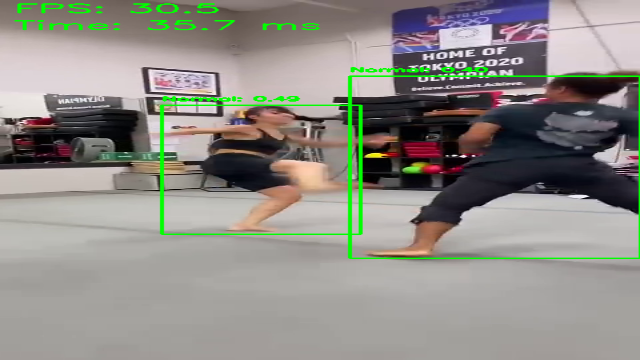


Detected 3 violence events:
Event 1: Start: 1.27s (Frame 38), End: 1.60s (Frame 48), Duration: 0.33s, Max Probability: 0.95
Event 2: Start: 3.80s (Frame 114), End: 4.47s (Frame 134), Duration: 0.67s, Max Probability: 0.92
Event 3: Start: 7.73s (Frame 232), End: 8.67s (Frame 260), Duration: 0.93s, Max Probability: 0.93
Output video saved to processed_WhatsApp Video 2025-03-02 at 11.44.04_afc97ec1 (1).mp4


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [13]:
# Real-Time Violence Detection System for Colab
# ============================================

import os
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import time
from collections import deque
import onnxruntime as ort
from datetime import datetime
from google.colab import files
from google.colab.patches import cv2_imshow
from IPython.display import clear_output, HTML, display
from tqdm.notebook import tqdm

class LightweightViolenceDetector(nn.Module):
    """Lightweight 3D CNN for violence detection based on MobileNetV3 principles"""

    def __init__(self, num_frames=8, num_classes=2):
        super(LightweightViolenceDetector, self).__init__()

        # Initial convolution layer
        self.conv1 = nn.Conv3d(3, 16, kernel_size=(3, 3, 3), stride=(1, 2, 2), padding=(1, 1, 1))
        self.bn1 = nn.BatchNorm3d(16)
        self.relu1 = nn.ReLU(inplace=True)

        # Inverted residual blocks (simplified from MobileNetV3)
        # Block 1
        self.block1_dw = nn.Conv3d(16, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), groups=16)
        self.block1_bn1 = nn.BatchNorm3d(16)
        self.block1_relu = nn.ReLU(inplace=True)
        self.block1_pw = nn.Conv3d(16, 32, kernel_size=1)
        self.block1_bn2 = nn.BatchNorm3d(32)

        # Block 2
        self.block2_dw = nn.Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 2, 2), padding=(1, 1, 1), groups=32)
        self.block2_bn1 = nn.BatchNorm3d(32)
        self.block2_relu = nn.ReLU(inplace=True)
        self.block2_pw = nn.Conv3d(32, 64, kernel_size=1)
        self.block2_bn2 = nn.BatchNorm3d(64)

        # Global average pooling and classification
        self.global_pool = nn.AdaptiveAvgPool3d((1, 1, 1))
        self.dropout = nn.Dropout(0.2)
        self.fc = nn.Linear(64, num_classes)

    def forward(self, x):
        # Initial convolution
        x = self.relu1(self.bn1(self.conv1(x)))

        # Block 1
        x = self.block1_relu(self.block1_bn1(self.block1_dw(x)))
        x = self.block1_bn2(self.block1_pw(x))

        # Block 2
        x = self.block2_relu(self.block2_bn1(self.block2_dw(x)))
        x = self.block2_bn2(self.block2_pw(x))

        # Global average pooling
        x = self.global_pool(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(x)

        # Classification
        x = self.fc(x)

        return x

class ViolenceDetectionSystem:
    """Real-time violence detection system for CCTV cameras"""

    def __init__(self, model_path, confidence_threshold=0.85, use_onnx=True, device="cuda"):
        self.confidence_threshold = confidence_threshold
        self.device = torch.device(device if torch.cuda.is_available() and device == "cuda" else "cpu")
        self.use_onnx = use_onnx and model_path.endswith(".onnx")

        # Load model
        if self.use_onnx:
            self.load_onnx_model(model_path)
        else:
            self.load_pytorch_model(model_path)

        # Initialize person detector (YOLOv5)
        self.load_person_detector()

        # Initialize frame buffer and trackers
        self.frame_buffer = deque(maxlen=8)
        self.processing_times = deque(maxlen=30)
        self.detections_history = deque(maxlen=10)

        # For tracking and reporting
        self.violence_events = []
        self.current_violence_event = None

        print(f"Violence detection system initialized on {self.device}")

    def load_onnx_model(self, model_path):
        """Load ONNX model for inference"""
        try:
            # Set up ONNX runtime session
            providers = ['CUDAExecutionProvider', 'CPUExecutionProvider'] if self.device.type == "cuda" else ['CPUExecutionProvider']
            self.session = ort.InferenceSession(model_path, providers=providers)
            self.input_name = self.session.get_inputs()[0].name
            self.model = None
            print(f"Loaded ONNX model from {model_path}")
        except Exception as e:
            print(f"Error loading ONNX model: {e}")
            raise

    def load_pytorch_model(self, model_path):
        """Load PyTorch model for inference"""
        try:
            self.model = LightweightViolenceDetector()
            self.model.load_state_dict(torch.load(model_path, map_location=self.device))
            self.model.to(self.device)
            self.model.eval()
            self.session = None
            print(f"Loaded PyTorch model from {model_path}")
        except Exception as e:
            print(f"Error loading PyTorch model: {e}")
            raise

    def load_person_detector(self):
        """Load YOLOv5 person detector"""
        try:
            self.person_detector = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True)
            self.person_detector.to(self.device)
            self.person_detector.classes = [0]  # Only detect people (class 0 in COCO)
            print("Person detector loaded successfully")
        except Exception as e:
            print(f"Error loading person detector: {e}")
            self.person_detector = None

    def detect_people(self, frame):
        """Detect people in frame using YOLOv5"""
        if self.person_detector is None:
            # Fallback: use whole frame
            height, width = frame.shape[:2]
            return [(0, 0, width, height, 1.0)]

        # Run inference
        results = self.person_detector(frame)

        # Extract person bounding boxes
        boxes = []
        for detection in results.xyxy[0]:  # xyxy format: [x1, y1, x2, y2, confidence, class]
            if detection[5] == 0:  # Class 0 is person
                if detection[4] > 0.5:  # Confidence threshold
                    x1, y1, x2, y2 = map(int, detection[:4])
                    confidence = detection[4].item()
                    boxes.append((x1, y1, x2, y2, confidence))

        # If no people detected, use whole frame
        if not boxes:
            height, width = frame.shape[:2]
            boxes.append((0, 0, width, height, 1.0))

        return boxes

    def preprocess_clip(self, frames):
        """Preprocess frames for violence detection"""
        # Resize frames
        resized_frames = [cv2.resize(frame, (224, 224)) for frame in frames]

        # Convert to tensor and normalize
        clip = torch.tensor(np.array(resized_frames) / 255.0, dtype=torch.float32)

        # Transpose from [T, H, W, C] to [C, T, H, W] for 3D CNN
        clip = clip.permute(3, 0, 1, 2)

        # Add batch dimension
        clip = clip.unsqueeze(0)

        return clip

    def detect_violence(self, clip):
        """Detect violence in clip"""
        if self.use_onnx:
            # ONNX inference
            ort_inputs = {self.input_name: clip.cpu().numpy()}
            ort_outputs = self.session.run(None, ort_inputs)
            scores = ort_outputs[0][0]

            # Convert to probabilities
            probabilities = F.softmax(torch.tensor(scores), dim=0)
        else:
            # PyTorch inference
            with torch.no_grad():
                clip = clip.to(self.device)
                outputs = self.model(clip)
                probabilities = F.softmax(outputs[0], dim=0)

        # Get violence probability (assuming class 1 is violence)
        violence_prob = probabilities[1].item()
        is_violent = violence_prob > self.confidence_threshold

        return is_violent, violence_prob

    def process_frame(self, frame, frame_idx=0, timestamp=None):
        """Process a single frame for violence detection"""
        start_time = time.time()

        # Make a copy for visualization
        vis_frame = frame.copy()

        # Add frame to buffer
        self.frame_buffer.append(frame)

        # Skip if buffer isn't full yet
        if len(self.frame_buffer) < 8:
            # Display that we're collecting frames
            cv2.putText(vis_frame, "Collecting frames...", (10, 30),
                       cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)

            processing_time = time.time() - start_time
            self.processing_times.append(processing_time)
            fps = 1.0 / (sum(self.processing_times) / len(self.processing_times))

            # Display FPS
            cv2.putText(vis_frame, f"FPS: {fps:.1f}", (10, 70),
                       cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

            return vis_frame, False, 0.0

        # Detect people
        person_boxes = self.detect_people(frame)

        # Track violence detections for this frame
        frame_has_violence = False
        max_violence_prob = 0.0

        # Process each person region
        for box in person_boxes:
            x1, y1, x2, y2, confidence = box

            # Extract person region from each frame in buffer
            person_clips = []
            for buffered_frame in self.frame_buffer:
                # Ensure valid coordinates
                valid_x1 = max(0, x1)
                valid_y1 = max(0, y1)
                valid_x2 = min(buffered_frame.shape[1], x2)
                valid_y2 = min(buffered_frame.shape[0], y2)

                if valid_x2 <= valid_x1 or valid_y2 <= valid_y1:
                    # Invalid region, use whole frame
                    region = buffered_frame
                else:
                    # Extract valid region
                    region = buffered_frame[valid_y1:valid_y2, valid_x1:valid_x2]

                person_clips.append(region)

            # Preprocess clip
            clip = self.preprocess_clip(person_clips)

            # Detect violence
            is_violent, violence_prob = self.detect_violence(clip)

            # Track maximum violence probability
            max_violence_prob = max(max_violence_prob, violence_prob)

            # Update frame violence status
            if is_violent:
                frame_has_violence = True

            # Draw bounding box
            color = (0, 0, 255) if is_violent else (0, 255, 0)
            cv2.rectangle(vis_frame, (x1, y1), (x2, y2), color, 2)

            # Add label
            label = f"Violent: {violence_prob:.2f}" if is_violent else f"Normal: {1-violence_prob:.2f}"
            cv2.putText(vis_frame, label, (x1, y1-10),
                       cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

        # Update detection history
        self.detections_history.append(frame_has_violence)

        # Apply temporal smoothing - violence is detected if majority of recent frames show violence
        smooth_violence = sum(self.detections_history) > len(self.detections_history) // 2

        # Track violence events
        if smooth_violence:
            if self.current_violence_event is None:
                # Start new violence event
                event_time = timestamp if timestamp else datetime.now().strftime("%Y-%m-%d %H:%M:%S")
                self.current_violence_event = {
                    "start_frame": frame_idx,
                    "start_time": event_time,
                    "end_frame": frame_idx,
                    "end_time": event_time,
                    "max_probability": max_violence_prob
                }
            else:
                # Update existing violence event
                self.current_violence_event["end_frame"] = frame_idx
                self.current_violence_event["max_probability"] = max(
                    self.current_violence_event["max_probability"], max_violence_prob
                )
                if timestamp:
                    self.current_violence_event["end_time"] = timestamp
                else:
                    self.current_violence_event["end_time"] = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
        elif self.current_violence_event is not None:
            # End violence event
            self.violence_events.append(self.current_violence_event)
            self.current_violence_event = None

        # Add violence alert
        if smooth_violence:
            cv2.putText(vis_frame, "VIOLENCE DETECTED!", (vis_frame.shape[1]//2 - 100, 30),
                       cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)

        # Calculate processing time and FPS
        processing_time = time.time() - start_time
        self.processing_times.append(processing_time)
        fps = 1.0 / (sum(self.processing_times) / len(self.processing_times))

        # Display FPS and processing time
        cv2.putText(vis_frame, f"FPS: {fps:.1f}", (10, 30),
                   cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
        cv2.putText(vis_frame, f"Time: {processing_time*1000:.1f} ms", (10, 70),
                   cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

        return vis_frame, smooth_violence, max_violence_prob

    def process_uploaded_video(self, output_path=None):
        """Process a video uploaded to Colab"""
        # Upload video
        print("Please upload a video file to process...")
        uploaded = files.upload()

        if not uploaded:
            print("No file uploaded.")
            return

        # Get uploaded video path
        video_path = next(iter(uploaded))

        # Process video
        if output_path is None:
            output_path = f"processed_{video_path}"

        self.process_video_file(video_path, output_path)

    def process_video_file(self, video_path, output_path=None, display_interval=30):
        """Process a video file for violence detection"""
        # Open video
        cap = cv2.VideoCapture(video_path)
        if not cap.isOpened():
            print(f"Error: Could not open video {video_path}")
            return

        # Get video properties
        width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
        height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
        fps = cap.get(cv2.CAP_PROP_FPS)
        frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

        print(f"Processing video: {video_path}")
        print(f"Resolution: {width}x{height}, FPS: {fps}, Frames: {frame_count}")

        # Create output video if requested
        if output_path:
            fourcc = cv2.VideoWriter_fourcc(*'mp4v')
            out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

        # Initialize frame counter and violence events
        frame_idx = 0
        self.violence_events = []
        self.current_violence_event = None

        # Create progress bar
        progress_bar = tqdm(total=frame_count, desc="Processing video")

        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                break

            # Process every other frame for speed (adjust as needed)
            if frame_idx % 2 == 0:
                # Calculate timestamp
                timestamp = f"{frame_idx/fps:.2f}s"

                # Process frame
                processed_frame, is_violent, _ = self.process_frame(frame, frame_idx, timestamp)

                # Write to output video if requested
                if output_path:
                    out.write(processed_frame)

                # Display progress
                if frame_idx % display_interval == 0:
                    # Show a frame periodically
                    if frame_idx > 0 and frame_idx % (display_interval * 10) == 0:
                        clear_output(wait=True)
                        # Display a frame
                        display_frame = cv2.resize(processed_frame, (640, 360))
                        cv2_imshow(display_frame)

            frame_idx += 1
            progress_bar.update(1)

        # Finalize last violence event if exists
        if self.current_violence_event is not None:
            self.violence_events.append(self.current_violence_event)

        # Release resources
        cap.release()
        if output_path:
            out.release()
        progress_bar.close()

        # Print violence events
        if self.violence_events:
            print(f"\nDetected {len(self.violence_events)} violence events:")
            for i, event in enumerate(self.violence_events):
                duration = (event['end_frame'] - event['start_frame']) / fps if fps > 0 else 0
                print(f"Event {i+1}: "
                      f"Start: {event['start_time']} (Frame {event['start_frame']}), "
                      f"End: {event['end_time']} (Frame {event['end_frame']}), "
                      f"Duration: {duration:.2f}s, "
                      f"Max Probability: {event['max_probability']:.2f}")
        else:
            print("\nNo violence detected in the video.")

        if output_path:
            print(f"Output video saved to {output_path}")
            # Download output video
            try:
                files.download(output_path)
            except Exception as e:
                print(f"Error downloading video: {e}")
                print("You can manually download the video from the file browser.")

        return self.violence_events

# Run this code to process a video
# Replace model_path with the path to your trained model
def run_violence_detection():
    # Paths to your model - adjust this to your actual model path
    model_path = "models/best_violence_detector.pth"  # or "models/violence_detector.onnx"

    # Check if model exists
    if not os.path.exists(model_path):
        print(f"Model not found at {model_path}!")
        print("Please specify the correct path to your trained model.")
        return

    # Initialize the violence detection system
    detector = ViolenceDetectionSystem(
        model_path=model_path,
        confidence_threshold=0.85,
        use_onnx=model_path.endswith('.onnx'),
        device="cuda"  # Change to "cpu" if no GPU available
    )

    # Process an uploaded video
    detector.process_uploaded_video()

# Run this to process a video
run_violence_detection()